# Исследование объявлений о продаже квартир

В распоряжении у меня данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Перечень основных задач:
- изучить общую информацию из датасета
- исследование и заполнение пропусков в данных
- избавление от явных и неявных дубликатов
- добавление в таблицу новых столбцов
- исследование параметров объектов
- исследование количества дней для продажи квартиры
- исследование факторов, влияющих на полную стоимость квартиры
- анализ десяти населённых пунктов с наибольшим числом объявлений, анализ стоимости квадратного метра
- анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра
- формулировка общего вывода

## Изучите данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head() #вывожу первые 5 строк для того чтобы понимать как выглядит датафрейм

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info() #общая информация о количестве не нулевых значений и типе данных в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

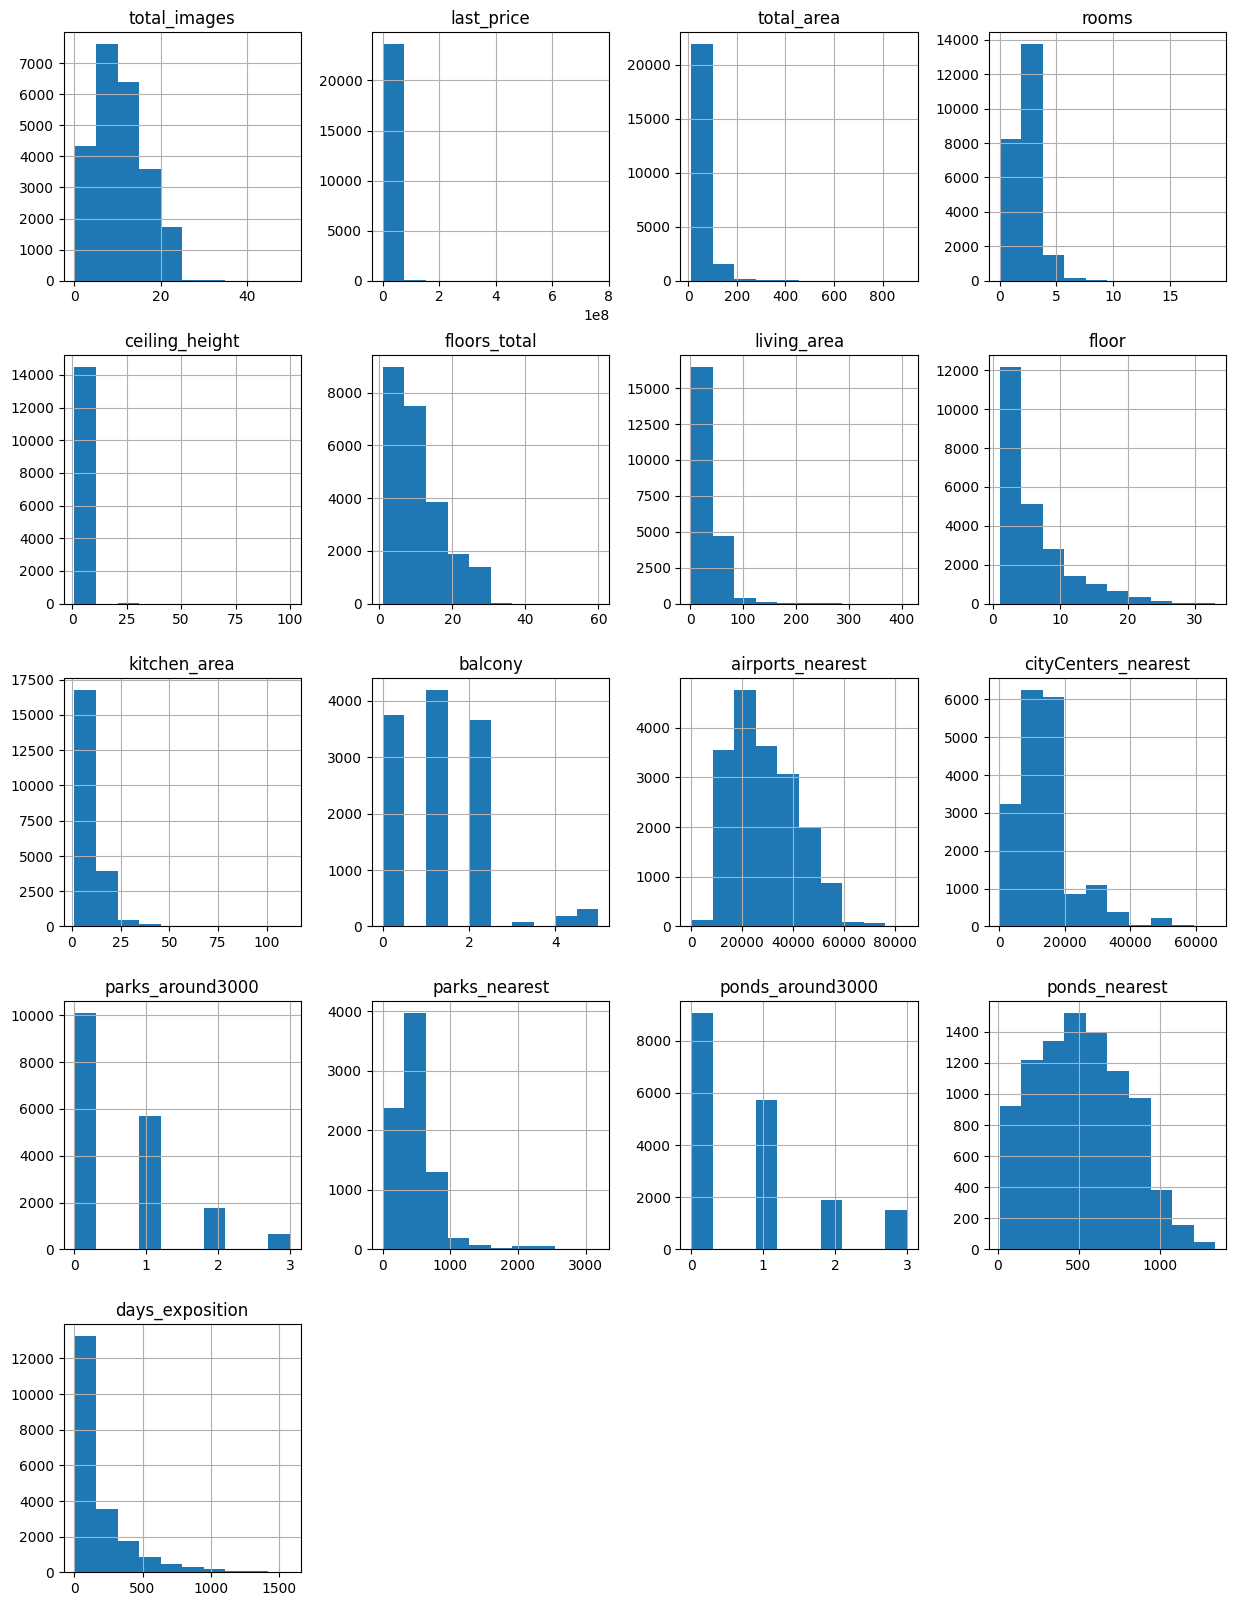

In [4]:
data.hist(figsize=(15, 20))#гистограмма для каждого столбца чтобы понимать как распределяются данные
plt.show()

Изучая данные гистограммы я заметил что большинство из них выглядят как распределение Пуассона.

In [5]:
data.describe() #метод describe для более полного понимания датафрейма

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Вывод:** Есть пропуски в некоторых столбцах, выбросы в минимальных и максимальных значениях и и также в некторых столбцах не тот тип данных.

## Предобработка данных

### Исследование и заполнение пропусков в данных

In [6]:
data.isna().sum() #Вывод числа пропусков в каждом столбце 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
print(data['ceiling_height'].describe())
print(data['ceiling_height'].var())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(data['ceiling_height'].describe())
print(data['ceiling_height'].var())
data.isna().sum() #Проверка того все ли пропуски в 'ceiling_height' заполнены

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
1.5902618088659135
count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64
0.9767338560068622


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
data = data.dropna(subset=['floors_total']) #Так как пропусков в этом столбце крайне мало, то можно их спокойно удалить
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

In [9]:
for area in data['total_area'].unique(): # Заполнил 'living_area' медианным значением по общей площади
    data.loc[(data['living_area'].isna()) & (data['total_area'] == area), 'living_area'] = \
    data.loc[data['total_area'] == area, 'living_area'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area               133
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

Так как я не могу найти способ качественно заполнить столбец 'is_apartment', то я оставлю всё как есть в нём. 

In [10]:
for area in data['total_area'].unique(): # Заполнил 'kitchen_area' медианным значением по столбцу 'total_area'
    data.loc[(data['kitchen_area'].isna()) & (data['total_area'] == area), 'kitchen_area'] = \
    data.loc[data['total_area'] == area, 'kitchen_area'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area               133
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area              185
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

In [11]:
data = data[data['total_area'] * 0.9 >= (data['living_area'] + data['kitchen_area'])]
data.count()

total_images            22699
last_price              22699
total_area              22699
first_day_exposition    22699
rooms                   22699
ceiling_height          22699
floors_total            22699
living_area             22699
floor                   22699
is_apartment             2677
studio                  22699
open_plan               22699
kitchen_area            22699
balcony                 11704
locality_name           22652
airports_nearest        17451
cityCenters_nearest     17474
parks_around3000        17475
parks_nearest            7746
ponds_around3000        17475
ponds_nearest            8689
days_exposition         19648
dtype: int64

In [12]:
data['balcony'] = data['balcony'].fillna(0) # Здесь я поставил 0 так как если продавец не указал количество балконов то их 
data.isna().sum() # скорее всего нет

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20022
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              47
airports_nearest         5248
cityCenters_nearest      5225
parks_around3000         5224
parks_nearest           14953
ponds_around3000         5224
ponds_nearest           14010
days_exposition          3051
dtype: int64

In [13]:
data = data.dropna(subset=['living_area', 'kitchen_area', 'locality_name']) #Так как пропусков в этих столбцах крайне мало,
data.isna().sum() #  то можно их спокойно удалить

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            19990
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5240
cityCenters_nearest      5217
parks_around3000         5216
parks_nearest           14921
ponds_around3000         5216
ponds_nearest           13987
days_exposition          3050
dtype: int64

In [14]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [15]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') # Поменял все ё на е так как много где только этим всё и 
data = data.replace('поселок городского типа Рябово', 'поселок Рябово') # отличается

In [16]:
# check
data.locality_name.nunique()

326

In [17]:
for name in data['locality_name'].unique(): # Заполнил 'airports_nearest' медианным значением по столбцу 'locality_name'
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == name), 'airports_nearest'] = \
    data.loc[data['locality_name'] == name, 'airports_nearest'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            19990
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5152
cityCenters_nearest      5217
parks_around3000         5216
parks_nearest           14921
ponds_around3000         5216
ponds_nearest           13987
days_exposition          3050
dtype: int64

In [18]:
for name in data['locality_name'].unique(): # Заполнил 'cityCenters_nearest' медианным значением по столбцу 'locality_name'
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == name), 'cityCenters_nearest'] = \
    data.loc[data['locality_name'] == name, 'cityCenters_nearest'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            19990
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5152
cityCenters_nearest      5152
parks_around3000         5216
parks_nearest           14921
ponds_around3000         5216
ponds_nearest           13987
days_exposition          3050
dtype: int64

In [19]:
for name in data['locality_name'].unique(): # Заполнил 'parks_nearest' медианным значением по столбцу 'locality_name'
    data.loc[(data['parks_nearest'].isna()) & (data['locality_name'] == name), 'parks_nearest'] = \
    data.loc[data['locality_name'] == name, 'parks_nearest'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            19990
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5152
cityCenters_nearest      5152
parks_around3000         5216
parks_nearest            5699
ponds_around3000         5216
ponds_nearest           13987
days_exposition          3050
dtype: int64

In [20]:
for name in data['locality_name'].unique(): # Заполнил 'ponds_nearest' медианным значением по столбцу 'locality_name'
    data.loc[(data['ponds_nearest'].isna()) & (data['locality_name'] == name), 'ponds_nearest'] = \
    data.loc[data['locality_name'] == name, 'ponds_nearest'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            19990
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5152
cityCenters_nearest      5152
parks_around3000         5216
parks_nearest            5699
ponds_around3000         5216
ponds_nearest            5236
days_exposition          3050
dtype: int64

Оставшиеся пропуски я не могу заполнить качественно так как не хватает данных.

In [21]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# меняю тип данных так как в этом столбце обозначено время

In [22]:
data['floors_total'] = data['floors_total'].astype('int64')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int64')

В столбцах 'floors_total' и 'balcony' я изменил тип данных, так как не может быть дробного этажа или балкона. В столбце 'is_apartment' изменён тип данных так как в описании данных написано, что это булев тип. 

In [23]:
data.duplicated().sum()

0

Явных дубликатов нет.

In [24]:
data.duplicated(subset=['total_area', 'floor', 'floors_total', 'cityCenters_nearest', 'locality_name', 'rooms']).sum()

198

In [25]:
(data
 .drop_duplicates(subset=['total_area', 'floor', 'floors_total', 'cityCenters_nearest', 'locality_name', 'rooms'])
 .reset_index()
)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.6,1,...,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,590.5,81.0
2,2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.3,4,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000.0,159.00,2015-07-24,3,2.65,14,95.0,9,...,15.00,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22449,23693,9,4600000.0,62.40,2016-08-05,3,2.60,9,40.0,8,...,8.00,0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
22450,23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
22451,23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.0,4,...,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
22452,23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.7,1,...,8.00,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data = data[(data['ceiling_height'] > 2) & (data['ceiling_height'] < 4)]
data = data[data['kitchen_area'] >= 5]
data = data[data['last_price'] <= 50000000]

Убраны аномалии связанные с высотой потолков, площадью кухни и ценой. Потолки выше 4 и ниже 2 метров вряд ли бывают. Минимальная площадь кухни в квартире 5 кв. м. Поэтому я убрал все значения меньше этого. А квартиры стоящие больше 50000000 руб. если они и есть то их крайне мало. 

In [27]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22333 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22333 non-null  int64         
 1   last_price            22333 non-null  float64       
 2   total_area            22333 non-null  float64       
 3   first_day_exposition  22333 non-null  datetime64[ns]
 4   rooms                 22333 non-null  int64         
 5   ceiling_height        22333 non-null  float64       
 6   floors_total          22333 non-null  int64         
 7   living_area           22333 non-null  float64       
 8   floor                 22333 non-null  int64         
 9   is_apartment          22333 non-null  bool          
 10  studio                22333 non-null  bool          
 11  open_plan             22333 non-null  bool          
 12  kitchen_area          22333 non-null  float64       
 13  balcony         

In [28]:
data.loc[data['rooms'] == 0, 'rooms'] = 1 #заменил все значения равные 0 в столбце 'rooms' так как не может быть 0 комнат

In [29]:
data = data[data['last_price'] >= 1000000] #так как сам не нашёл квартиры дешевле 1 миллиона

In [30]:
data = data[data['living_area'] >= 5] #так как значения меньше не реалистичны

In [31]:
data = data[data['kitchen_area'] <= 80] #так как значения больше крайне редки и их можно отбросить

In [32]:
data = data[data['floors_total'] <= 36] #так как я нашёл что самое высокое жилое здание в Питере это 
#ЖК "Александр Невский"-36 этажей

In [33]:
data = data[data['rooms'] < 7]

In [34]:
data = data.query('days_exposition.isna() | days_exposition > 2')

In [35]:
data.count()

total_images            22051
last_price              22051
total_area              22051
first_day_exposition    22051
rooms                   22051
ceiling_height          22051
floors_total            22051
living_area             22051
floor                   22051
is_apartment            22051
studio                  22051
open_plan               22051
kitchen_area            22051
balcony                 22051
locality_name           22051
airports_nearest        17164
cityCenters_nearest     17164
parks_around3000        17102
parks_nearest           16621
ponds_around3000        17102
ponds_nearest           17083
days_exposition         19127
dtype: int64

## Добавление в таблицу новых столбцов

In [36]:
data['metr_price'] = data['last_price'] / data['total_area'] # Нахожу цену одного квадратного метра
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,590.5,81.0,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474


In [37]:
data['weekday'] = data['first_day_exposition'].dt.weekday # Нахожу день недели публикации объявления
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,590.5,81.0,82920.792079,1
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0


In [38]:
data['month'] = data['first_day_exposition'].dt.month # Нахожу месяц пубдикации объявления
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,12817.0,18603.0,0.0,NaN,0.0,590.5,81.0,82920.792079,1,12
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0,9


In [39]:
data['year'] = data['first_day_exposition'].dt.year # Нахожу год пубдикации объявления
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,18603.0,0.0,NaN,0.0,590.5,81.0,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0,9,2018


In [40]:
def floors_category(floor): # Создал функцию, которая присвоит категорию исходя из этажа
    total_floor = floor['floors_total']
    floors = floor['floor']
    if floors == 1:
        return 'первый'
    if floors == total_floor:
        return 'последний'
    if 1 < floors < total_floor:
        return 'другой'

data['floor_category'] = data.apply(floors_category, axis=1)
data['floor_category'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

In [41]:
data['citycentres_km'] = round(data['cityCenters_nearest'] / 1000) # Нахожу расстояние до центра города в км
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month,year,floor_category,citycentres_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,NaN,0.0,590.5,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN


## Исследовательский анализ данных

### Исследование параметров объектов: общей площади, жилой площади, площади кухни, цены, количества комнат и т.д.

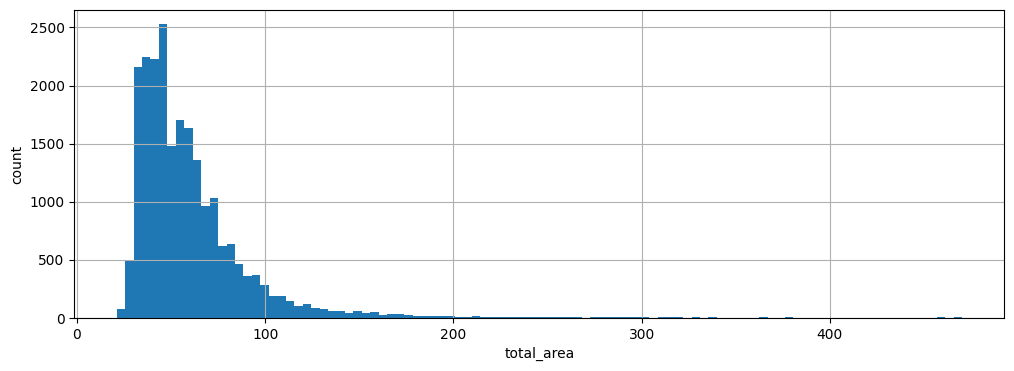

In [42]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('total_area')
ax.set_ylabel('count')
data['total_area'].hist(bins=100, figsize=(12, 4)) # общая площадь
plt.show()

**Вывод:** Исходя из гистограммы можно сделать вывод, что большинство квартир имеют площадь 30 - 70 кв. м.

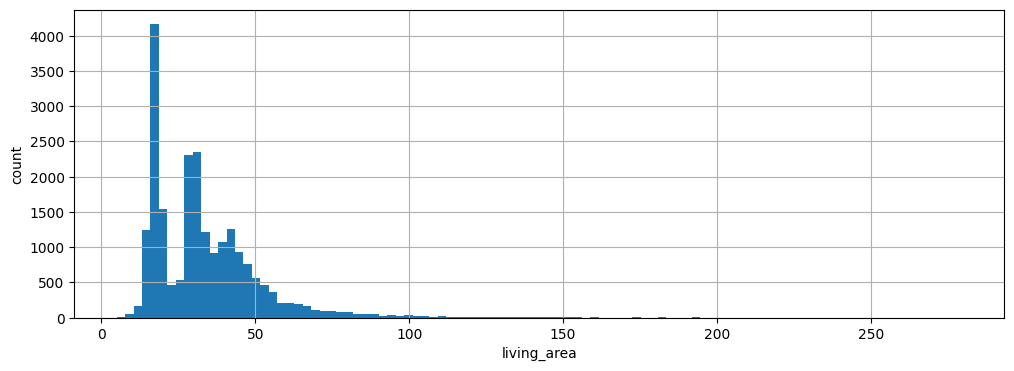

In [43]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('living_area')
ax.set_ylabel('count')
data['living_area'].hist(bins=100, figsize=(12, 4)) # жилая площадь
plt.show()

**Вывод:** В данном случае есть 2 пика, которые расположены очень близко друг к другу это примерно 20 и 28 кв. м. Я не считаю это какой либо аномалией так как они расположены очень близко друг к другу.

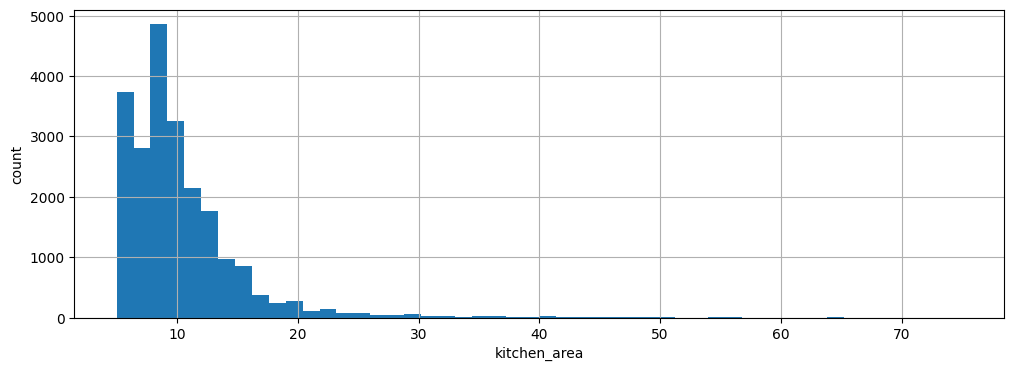

In [44]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('kitchen_area')
ax.set_ylabel('count')
data['kitchen_area'].hist(bins=50, figsize=(12, 4)) # площадь кухни
plt.show()

**Вывод:** Здесь ситуация похожа на предыдущую, но во первых пики почти одинаковые и провал между ними совсем небольшой. Пики располагаются примерно на 5 и 9 кв. м.

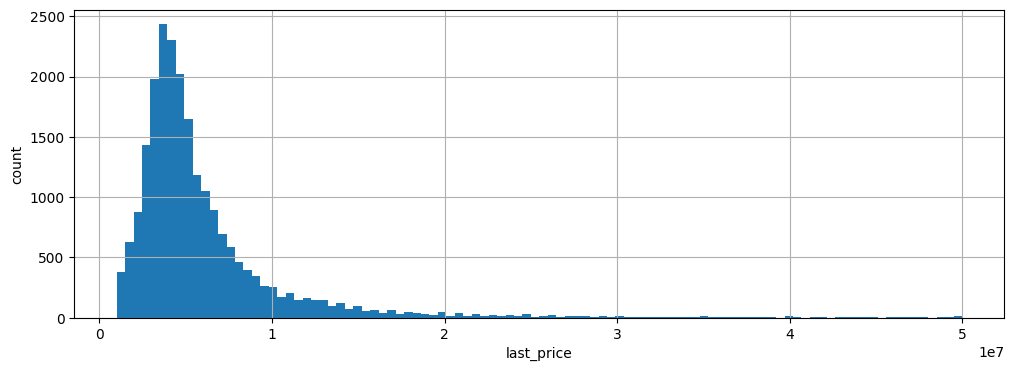

In [45]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('last_price')
ax.set_ylabel('count')
data['last_price'].hist(bins=100, figsize=(12, 4)) # цена
plt.show()

**Вывод:** Самая частая цена продажи в районе от 3 до 4 миллионов руб.

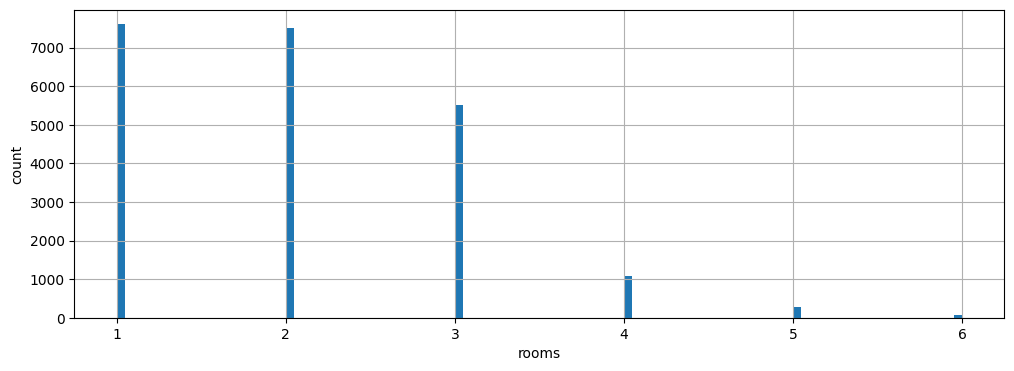

In [46]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('rooms')
ax.set_ylabel('count')
data['rooms'].hist(bins=100, figsize=(12, 4)) # количество комнат
plt.show()

**Вывод:** У абсолютного большинства квартир 1 или 2 комнаты, чуть реже 3, а все остальные значения по сравнению с этими тремя очень маленькие.

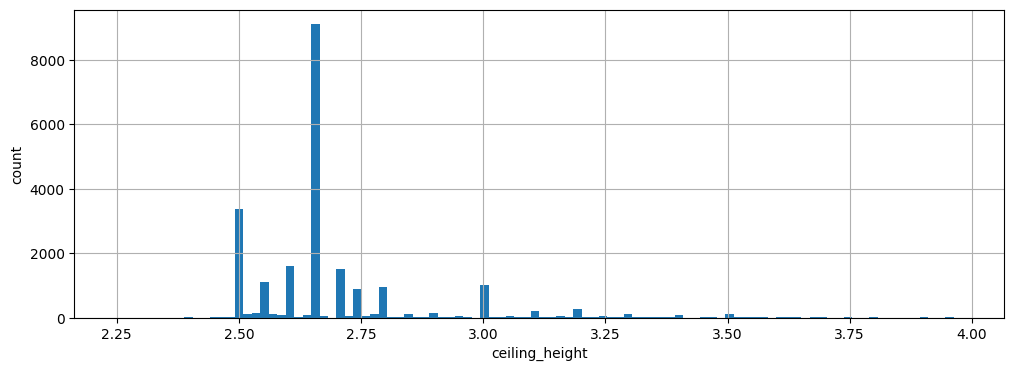

In [47]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('ceiling_height')
ax.set_ylabel('count')
data['ceiling_height'].hist(bins=100, figsize=(12, 4)) # высота потолков
plt.show()

**Вывод:** На фоне всех значений очень сильно выделяется одно - примерно 2.65 м. так как это медиана. Если закрыть глаза на неё то самое частое значение это 2.5 м

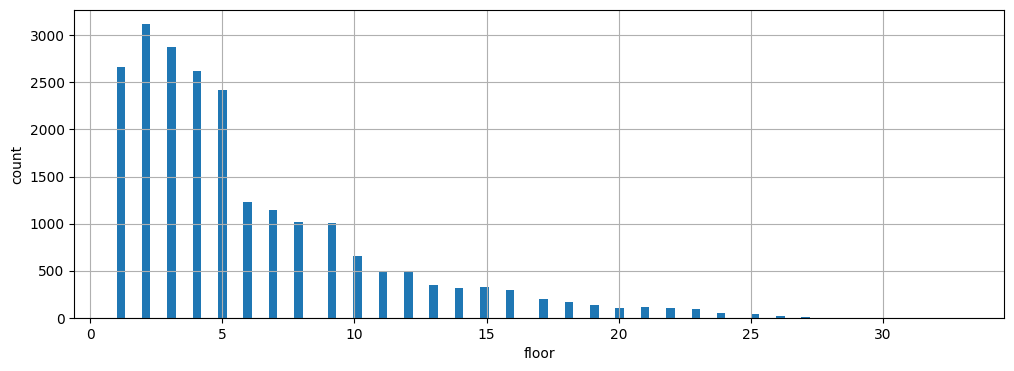

In [48]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('floor')
ax.set_ylabel('count')
data['floor'].hist(bins=100, figsize=(12, 4)) # этаж квартиры
plt.show()

**Вывод:** Большинство квартир находятся на 1 - 5 этажах. Это объясняется тем что у нас много пятиэтажек.

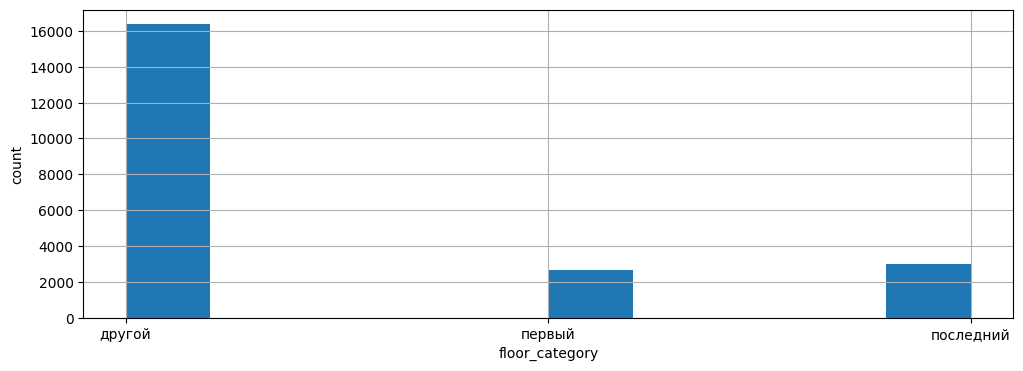

In [49]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('floor_category')
ax.set_ylabel('count')
data['floor_category'].hist(bins=10, figsize=(12, 4)) # категория этажа квартиры
plt.show()

**Вывод:** Абсолютное большинство квартир расположены не на первом и последнем этаже, что вполне логично.

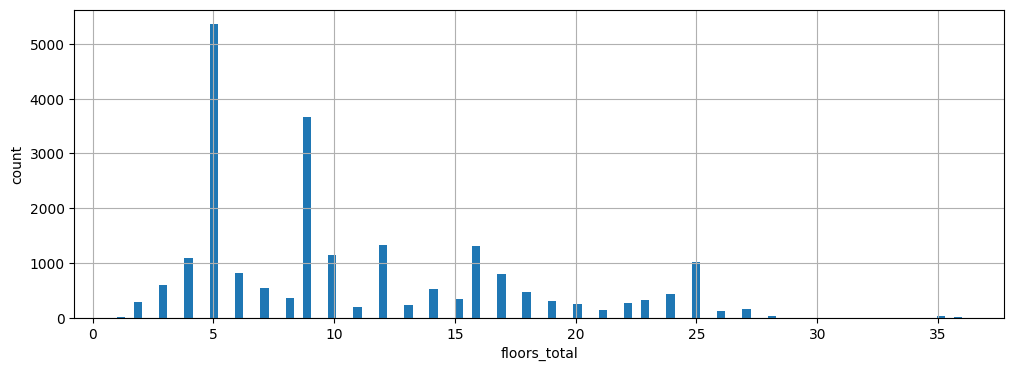

In [50]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('floors_total')
ax.set_ylabel('count')
data['floors_total'].hist(bins=100, figsize=(12, 4)) # количество этажей в доме
plt.show()

**Вывод:** Данная гистограмма подтверждает один из предыдущих выводов, что у нас много пятиэтажек.

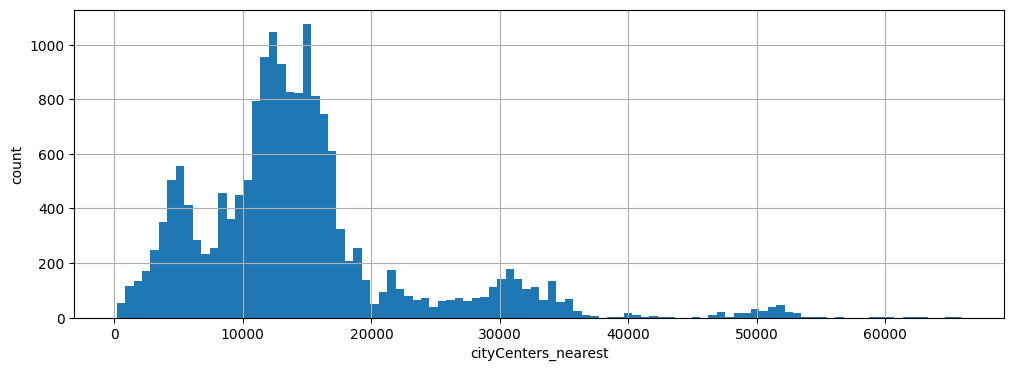

In [51]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('cityCenters_nearest')
ax.set_ylabel('count')
data['cityCenters_nearest'].hist(bins=100, figsize=(12, 4)) # расстояние до центра города в метрах
plt.show()

**Вывод:** На данной гистограмме видно, что большинство квартир расположены на расстоянии 12 - 15 км. от центра города.

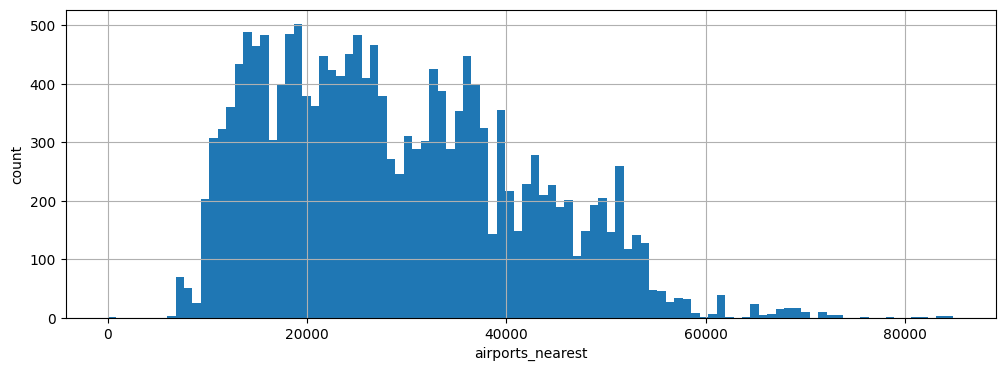

In [52]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('airports_nearest')
ax.set_ylabel('count')
data['airports_nearest'].hist(bins=100, figsize=(12, 4)) # расстояние до ближайшего аэропорта
plt.show()

**Вывод:** В основном расстояние до ближайшего аэропорта в районе 20 км.

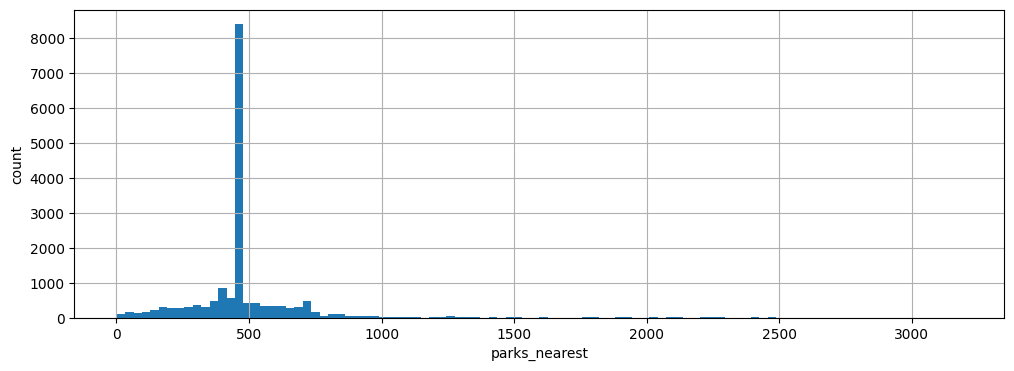

In [53]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('parks_nearest')
ax.set_ylabel('count')
data['parks_nearest'].hist(bins=100, figsize=(12, 4)) # расстояние до ближайшего парка
plt.show()

**Вывод:** Здесь на фоне других очень сильно выделяется одно значение, которое чуть меньше 500 метров, но выделяется так как это медиана. Если опустить это значение то самое частое значение в районе 450 метров

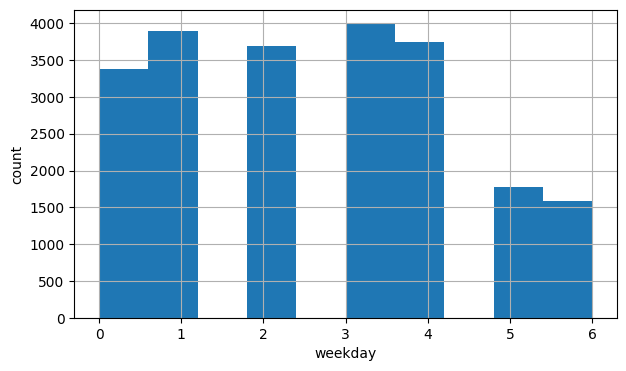

In [54]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('weekday')
ax.set_ylabel('count')
data['weekday'].hist(bins=10) # день публикации объявления
plt.show()

**Вывод:** В основном квартиры на продажу выставляют в будние дни.

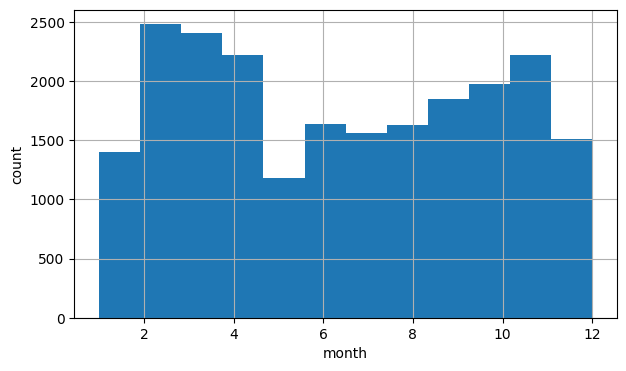

In [55]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.set_xlabel('month')
ax.set_ylabel('count')
data['month'].hist(bins=12) # месяц публикации объявления
plt.show()

**Вывод:** Здесь видно, что в основном публикуют объявдения с февраля по апрель и с сентября по ноябрь, а меньше всего в мае.

### Исследование количества дней для продажи квартиры

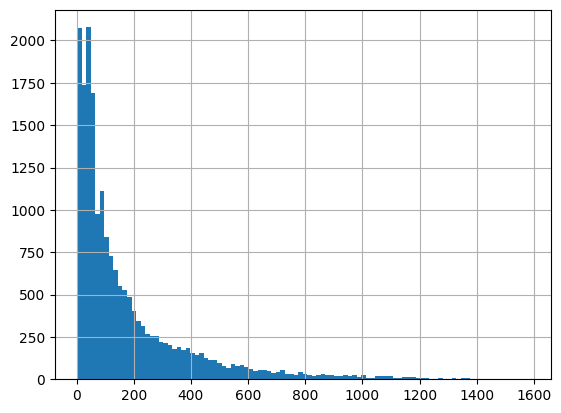

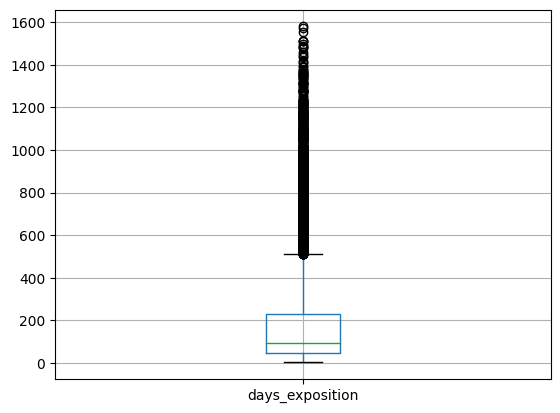

Среднее арифметическое равно: 180.88780258273644
Медиана равна: 96.0
Минимальное значение равно: 3.0000000000000004
Максимальное значение равно: 1580.0


In [56]:
data['days_exposition'].hist(bins=100) 
plt.show()
data.boxplot('days_exposition')
plt.show()
print('Среднее арифметическое равно:', data['days_exposition'].mean())
print('Медиана равна:', data['days_exposition'].median())
print('Минимальное значение равно:', data['days_exposition'].min())
print('Максимальное значение равно:', data['days_exposition'].max())

**Вывод:** В среднем продажа квартиры занимает 181 день, что примрно равно полугоду, при том что медиана равна 96, что почти в 2 раза меньше. Быстрыми можно считать продажи меньше 50 дней. Долгими можно считать продажи более 250 дней.

In [57]:
data.groupby('year')['days_exposition'].mean() #изменение средней скорости продаж по годам

year
2014    922.110092
2015    652.627432
2016    321.542279
2017    159.231977
2018     94.182038
2019     30.745984
Name: days_exposition, dtype: float64

Видно что средняя скорость продажи очень быстро уменьшается

### Исследование факторов, влияющих на полную стоимость квартиры

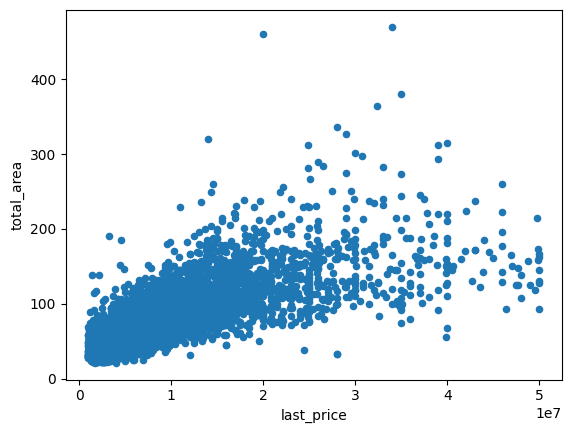

0.7731265045988828

In [58]:
data.plot(x='last_price', y='total_area', kind='scatter') # использую диаграмму рассения так как в обоих столбцах содержатся
plt.show() # колличественные значения
data['last_price'].corr(data['total_area'])

**Вывод:** Присутствует достаточно сильная корреляция.

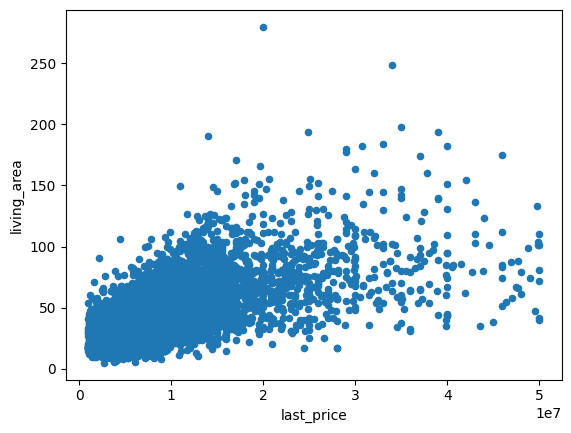

0.674505498656414

In [59]:
data.plot(x='last_price', y='living_area', kind='scatter')
plt.show()
data['last_price'].corr(data['living_area'])

**Вывод:** В данном случае корреляция меньше.

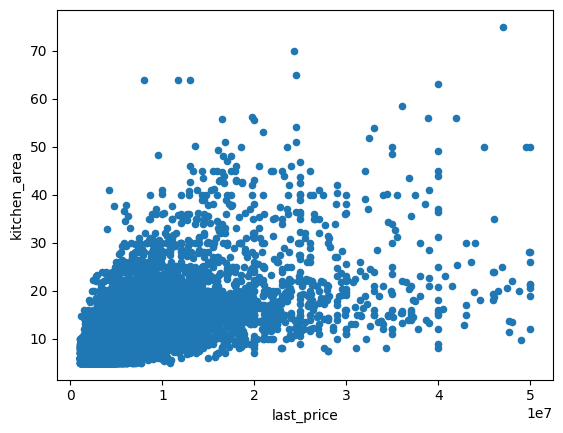

0.6057159546843519

In [60]:
data.plot(x='last_price', y='kitchen_area', kind='scatter')
plt.show()
data['last_price'].corr(data['kitchen_area'])

**Вывод:** Здесь корреляция ещё меньше.

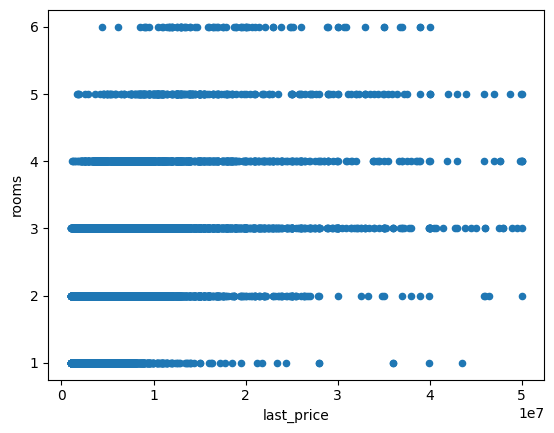

0.47994210698731216

In [61]:
data.plot(x='last_price', y='rooms', kind='scatter')
plt.show()
data['last_price'].corr(data['rooms'])

**Вывод:** В данном случае корреляция ещё меньше.

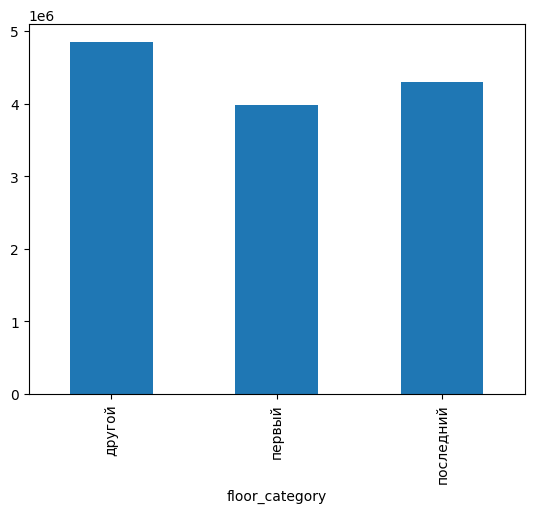

In [62]:
data.groupby('floor_category')['last_price'].median().plot(kind='bar')
plt.show()

**Вывод:** Цена на квартиры на первом этаже меньше скорее всего так как самих квартир на первом этаже меньше и это сказывается на результате

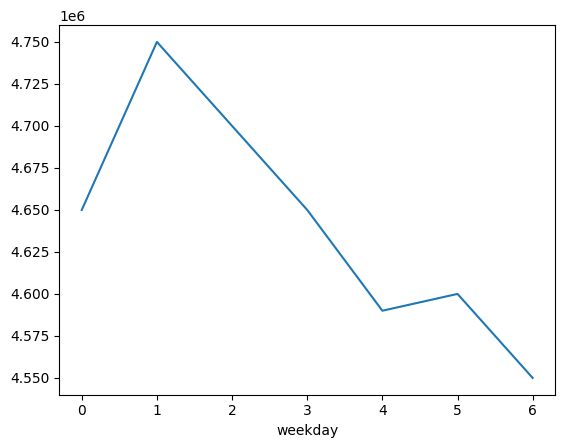

In [63]:
data.groupby('weekday')['last_price'].median().plot(x='weekday', y='last_price')
plt.show()

**Вывод:** В воскресенье цена ниже чем в остальные дни. А самая большая цена во вторник и в среду

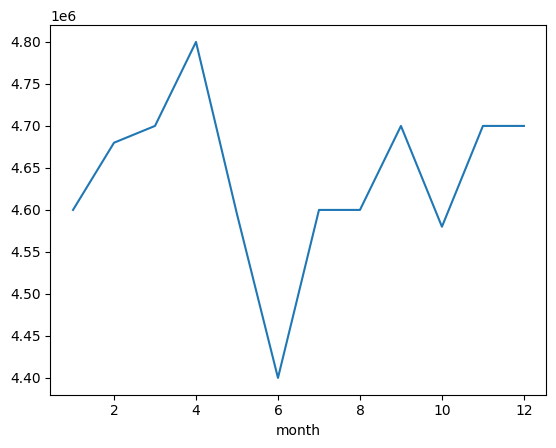

In [64]:
data.groupby('month')['last_price'].median().plot(x='month', y='last_price')
plt.show()

**Вывод:** В июне цены самые низкие

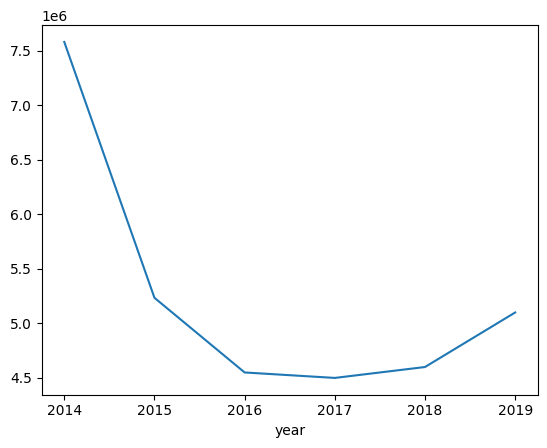

In [65]:
data.groupby('year')['last_price'].median().plot(x='year', y='last_price')
plt.show()

In [66]:
data.pivot_table(index='year', values=['last_price', 'total_area'], aggfunc={'mean', 'count'})

last_price               total_area           
          count          mean      count       mean
year                                               
2014        127  1.063382e+07        127  82.265276
2015       1092  6.990130e+06       1092  67.518516
2016       2580  6.061812e+06       2580  60.586504
2017       7690  5.824938e+06       7690  58.713967
2018       7891  5.720573e+06       7891  57.210056
2019       2671  6.272371e+06       2671  57.637473

**Вывод:** С 2014 года цена снижалась до 2017, а после снова начала подниматься. Количество объявлений наоборот росло до 2018, а потом резко упало. При том что площадь с каждым годом понижалась, и только в 2019 средняя площадь чуть чуть увеличилась. Цена же падала с 2014 до 2018 и в 2019 возросла 

In [67]:
# check
round(data.query('year == 2014')['last_price'].mean())

10633823

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Скажи пожалуйста, на графике какие цифры мы отображаем?
        
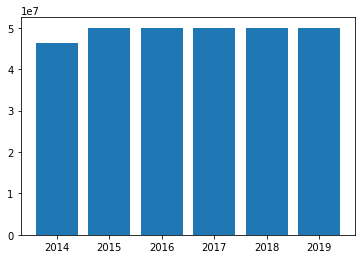        
        
Стоит пересмотреть способ отрисовки последних 4-ех графиков
        
       
        
Советы по графикам:
        
+ зависимость параметров (от площади, удалённости от центра) оптимальнее рассматривать на точечных графиках (тип scatter),
+ динамику на линейных (это про сравнение цен за год, месяц, день недели), — стоит сгруппировать значения и рассчитать среднее или медианное значение 
+ сравнение цен на барах (для сравнение средней стоимости квартиры по трем категориям), — стоит сгруппировать значения и рассчитать среднее или медианное значение

### Анализ десяти населённых пунктов с наибольшим числом объявлений, анализ стоимости квадратного метра;

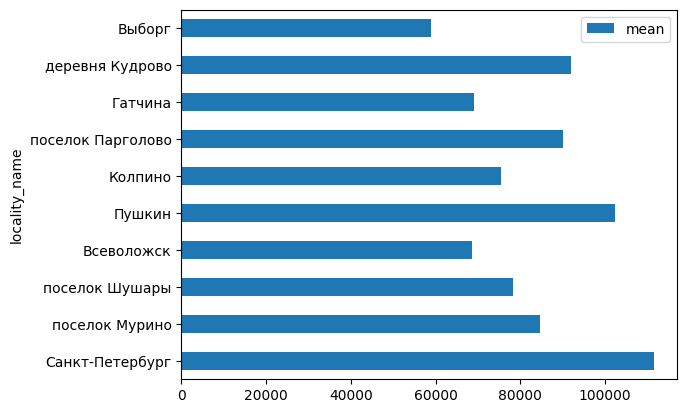

,count,mean
locality_name,,
Санкт-Петербург,14750,111531.98
поселок Мурино,477,84551.74
поселок Шушары,432,78292.66
Всеволожск,375,68566.16
Пушкин,355,102395.23
Колпино,331,75382.03
поселок Парголово,321,90115.05
Гатчина,292,69062.54
деревня Кудрово,272,92010.28


In [68]:
average_price = data.pivot_table(index='locality_name', values='metr_price', aggfunc={'mean', 'count'})
average_price = average_price.sort_values(by='count', ascending=False)
average_price['mean'] = round(average_price['mean'], ndigits=2)
average_price.head(10).plot(y='mean', kind='barh')
plt.show()
average_price.head(10)

**Вывод:** Больше всего объявлений в Питере и близлежащих к нему населённых пунктах.

### Анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра

In [69]:
data['citycentres_km'] = data['citycentres_km'] 
spb = (data
       .loc[data['locality_name'] == 'Санкт-Петербург']
       .pivot_table(index='citycentres_km', values='last_price', aggfunc={'mean'}))
print('Корреляция равна:', data['last_price'].corr(data['citycentres_km']))
spb

Корреляция равна: -0.3273426613789835


,mean
citycentres_km,
0.0,1.898231e+07
1.0,1.252927e+07
2.0,1.187877e+07
3.0,1.016672e+07
4.0,1.084573e+07
5.0,1.136358e+07
6.0,1.163689e+07
7.0,1.132095e+07
8.0,9.125651e+06


**Вывод:** Как и ожидалось чем дальше от центра города тем меньше цена.

In [70]:
print(data[(data['citycentres_km'] == 26) & (data['locality_name'] == 'Санкт-Петербург')]['last_price'].describe())
data[(data['citycentres_km'] == 27) & (data['locality_name'] == 'Санкт-Петербург')]['last_price'].describe()

count    3.400000e+01
mean     3.880834e+06
std      1.277810e+06
min      2.600000e+06
25%      3.150000e+06
50%      3.310000e+06
75%      4.106250e+06
max      7.900000e+06
Name: last_price, dtype: float64


count    2.000000e+00
mean     8.300000e+06
std      8.555992e+06
min      2.250000e+06
25%      5.275000e+06
50%      8.300000e+06
75%      1.132500e+07
max      1.435000e+07
Name: last_price, dtype: float64

**Вывод:** Дело в том что на 27 км всего 2 квартиры, когда на том же 26 км их 33, и одна из этих двух квартир стоит целых 14 миллионов, что почти в 2 раза больше чем на 26 км. В итоге получается эта аномалия вызвана малым количеством квартир на 27 км.

In [71]:
print(data
 .query('citycentres_km == 3 and floor_category == "первый"')['floors_total'].count()
)
print(data
 .query('citycentres_km == 3 and floor_category == "последний"')['floors_total'].count()
)
(data
 .query('citycentres_km == 3 and floor_category == "другой"')['floors_total'].count()
)

52
71


185

Количество квартир разных категорий на 3 км

In [72]:
print(data
 .query('citycentres_km == 3 and floor_category == "первый"')['floors_total'].count() / 
 data.query('citycentres_km == 3')['floors_total'].count() * 100
)
print(data
 .query('citycentres_km == 3 and floor_category == "последний"')['floors_total'].count() / 
 data.query('citycentres_km == 3')['floors_total'].count() * 100
)
(data
 .query('citycentres_km == 3 and floor_category == "другой"')['floors_total'].count() / 
 data.query('citycentres_km == 3')['floors_total'].count() * 100
)

16.883116883116884
23.051948051948052


60.064935064935064

Доля квартир разных категорий на 3 км

In [73]:
print(data
 .query('citycentres_km == 5 and floor_category == "первый"')['floors_total'].count()
)
print(data
 .query('citycentres_km == 5 and floor_category == "последний"')['floors_total'].count()
)
(data
 .query('citycentres_km == 5 and floor_category == "другой"')['floors_total'].count()
)

69
117


627

Количество квартир разных категорий на 5 км

In [74]:
print(data
 .query('citycentres_km == 5 and floor_category == "первый"')['floors_total'].count() / 
 data.query('citycentres_km == 5')['floors_total'].count() * 100
)
print(data
 .query('citycentres_km == 5 and floor_category == "последний"')['floors_total'].count() / 
 data.query('citycentres_km == 5')['floors_total'].count() * 100
)
(data
 .query('citycentres_km == 5 and floor_category == "другой"')['floors_total'].count() / 
 data.query('citycentres_km == 5')['floors_total'].count() * 100
)

8.487084870848708
14.391143911439114


77.12177121771218

Доля квартир разных категорий на 5 км

## Общий вывод

**Общий вывод:** На цену квартиры достаточно сильно влияет общая площадь. В меньшей мере влияет жилая площадь, площадь кухни и количество комнат. Также на цену квартиры немного влияет день недели, в который выложили объявление, а именно в воскресенье цена ниже чем в остальные дни. Также влияет месяц, а именно в июне цены самые низкие. И в конце концов на цену квартиры именно в Питере влияет удалённость её от центра города, что в принципе логично так как в центре расположена вся инфраструктура, и соответственно там будет дороже.